# Supervised Machine Learning Logistic Regression Model

In [1]:
# import dependencies
from getpass import getpass
import sqlalchemy
from sqlalchemy import Column, Integer, String, ForeignKey, create_engine, text
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced
from collections import Counter

/Users/joeymyers/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Establish connection with Database and read in table

In [2]:
# SQL Alchemy connection from RDS
secret = getpass('Enter the secret value: ')

args ={
    'host':"ogdataset.c11hekhsylui.us-west-1.rds.amazonaws.com",
    'port':'5432',
    'database':"og_dataset",
    'user':"attritionProject",
    'password':secret
}
engine = create_engine("postgresql://{user}:{password}@{host}:{port}/{database}".format(**args))
connection = engine.connect()

Enter the secret value: ········


In [3]:
# read in table from database
attrition_df = pd.read_sql('SELECT * FROM new_encoded_data', connection)
attrition_df

,Age,Attrition,Business Travel,Department,Distance from Home,Education Level,Education Field,Environment Satisfaction,Gender,Job Involvement,...,Performance Rating,Relationship Satisfaction,Stock Option Level,Total Working Years,Training Times Last Year,Work Life Balance,Years at Company,Years In Current Role,Years Since Last Promotion,Years With Current Manager
0,41,1,2,2,1,2,1,2,0,3,...,3,1,0,8,0,1,6,4,0,5
1,49,0,1,1,8,1,1,3,1,2,...,4,4,1,10,3,3,10,7,1,7
2,37,1,2,1,2,2,4,4,1,2,...,3,2,0,7,3,3,0,0,0,0
3,33,0,1,1,3,4,1,4,0,3,...,3,3,0,8,3,3,8,7,3,0
4,27,0,2,1,2,1,3,1,1,3,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,1,1,23,2,3,3,1,4,...,3,3,1,17,3,3,5,2,0,3
1466,39,0,2,1,6,1,3,4,1,2,...,3,1,1,9,5,3,7,7,1,7
1467,27,0,2,1,4,3,1,2,1,4,...,4,2,1,6,0,3,6,2,0,3
1468,49,0,1,2,2,3,3,4,1,2,...,3,4,0,17,3,2,9,6,0,8


# Identify Multicollinearity

In [4]:
cols = attrition_df.columns
cols

Index(['Age', 'Attrition', 'Business Travel', 'Department',
       'Distance from Home', 'Education Level', 'Education Field',
       'Environment Satisfaction', 'Gender', 'Job Involvement', 'Job Level',
       'Job Role', 'Job Satisfaction', 'Marital Status', 'Monthly Income',
       'Number Companies Worked', 'Overtime', 'Percent Salary Hike',
       'Performance Rating', 'Relationship Satisfaction', 'Stock Option Level',
       'Total Working Years', 'Training Times Last Year', 'Work Life Balance',
       'Years at Company', 'Years In Current Role',
       'Years Since Last Promotion', 'Years With Current Manager'],
      dtype='object')

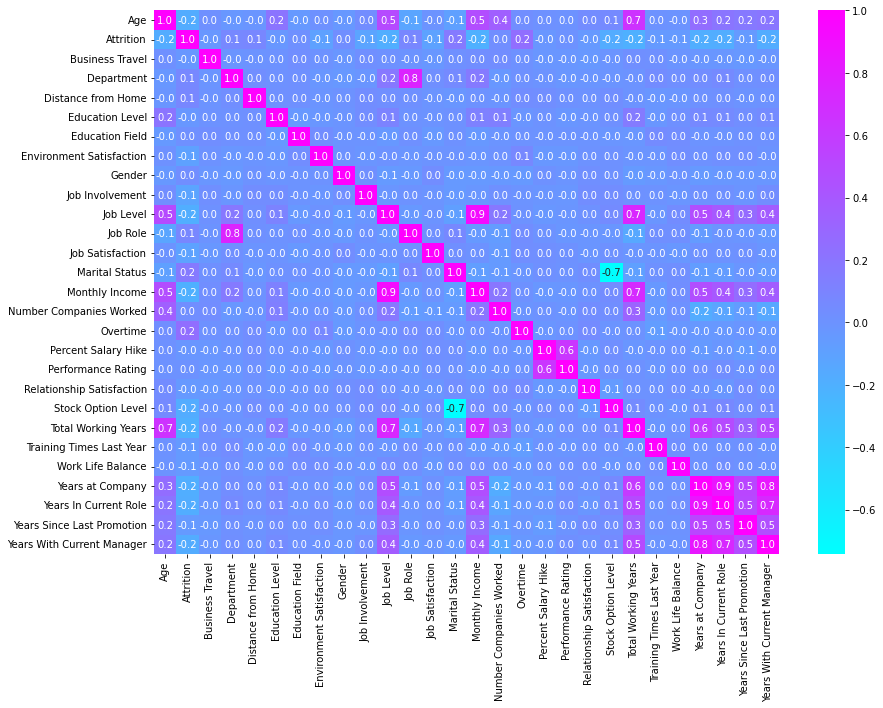

In [5]:
# heatmap to visualize where mulitcollinearity exists
figure = plt.figure(figsize=(14,10))
sns.heatmap(attrition_df[cols].corr(method = 'spearman'),
                annot=True, 
                fmt = ".1f", 
                cmap = "cool")
plt.show()
figure.savefig("correlation_heatmap.png")

In [6]:
# drop strongly correlated columns to improve model
attrition_df.drop(['Total Working Years','Years In Current Role','Job Level', 'Years With Current Manager'],axis=1, inplace=True)

In [7]:
# columns
attrition_df.columns

Index(['Age', 'Attrition', 'Business Travel', 'Department',
       'Distance from Home', 'Education Level', 'Education Field',
       'Environment Satisfaction', 'Gender', 'Job Involvement', 'Job Role',
       'Job Satisfaction', 'Marital Status', 'Monthly Income',
       'Number Companies Worked', 'Overtime', 'Percent Salary Hike',
       'Performance Rating', 'Relationship Satisfaction', 'Stock Option Level',
       'Training Times Last Year', 'Work Life Balance', 'Years at Company',
       'Years Since Last Promotion'],
      dtype='object')

# Evaluate discrepancy between attrition values

In [8]:
# determine how many yes/no (1/0) values we have
attrition_df["Attrition"].value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

# Split data into training and test groups

In [9]:
# Split our preprocessed data into our features and target arrays
X = attrition_df.drop("Attrition",1).values
y = attrition_df["Attrition"].values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, stratify=y)

/Users/joeymyers/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


# Resample with SMOTE

In [10]:
# Using the SMOTE oversampling technique increase the number of minority class (Yes values)
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)

In [11]:
# Count the resampled classes
Counter(y_resampled)

Counter({1: 924, 0: 924})

# Create and Train Model

In [12]:
# create a LogisticRegression instance
model = LogisticRegression(max_iter=200)

In [13]:
# fit/train the model to classify Attrition using the resampled data set
model.fit(X_resampled, y_resampled)

/Users/joeymyers/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(max_iter=200)

# Evaluation Metrics

In [14]:
# Display the confusion matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[229,  80],
       [ 25,  34]])

In [15]:
# Assess the Model's Accuracy w/ the Balanced Accuracy Score
balanced_accuracy_score(y_test, y_pred)

0.6586857550326367

In [16]:
# Print the imbalanced classification report to evaluate the precision and sensitivity of the model
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.74      0.58      0.81      0.65      0.43       309
          1       0.30      0.58      0.74      0.39      0.65      0.42        59

avg / total       0.80      0.71      0.60      0.75      0.65      0.43       368



# write the model, scaler to a a pickle file

In [ ]:
# write the model to a external model.pkl file
model_file = "../resources/model.pkl"
pickle.dump(model, open(model_file, "wb"))

In [ ]:
# # write the scaler to a external model.pkl file
# scaler_file = "../resources/scaler.pkl"
# pickle.dump(sc, open(scaler_file, "wb"))